In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import re
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import numpy as np

In [2]:
import re
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Load the dataset
data_train = pd.read_csv('Training.csv')
data_test = pd.read_csv('Test.csv')

# Print the NaN counts in test dataset
print(data_test.isnull().sum())

# Discard columns having many NaN values
columns_to_drop = ['reviewerName', 'image', 'style', 'category']
data_train = data_train.drop(columns_to_drop, axis=1)
data_test = data_test.drop(columns_to_drop, axis=1)

# Fill NaN values in 'summary' with empty strings
data_train['summary'] = data_train['summary'].replace(np.nan, '')
data_test['summary'] = data_test['summary'].replace(np.nan, '')

# Fill NaN values in 'vote' with 0
data_train['vote'] = data_train['vote'].replace(np.nan, 0)
data_test['vote'] = data_test['vote'].replace(np.nan, 0)

# Encode 'overall' ratings as multi-class labels
data_train['label'] = data_train['overall'].map(int)
data_test['label'] = -1  # For test data, label is a placeholder

# Text preprocessing
def preprocess_text(input_text):
    input_text = input_text.lower()
    input_text = re.sub(r'[^\w\s]', '', input_text)
    input_text = re.sub(r'\d+', '', input_text)
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    stop_words = TfidfVectorizer(stop_words='english').get_stop_words()
    words = [word for word in input_text.split() if word not in stop_words]
    return ' '.join(words)

# Define ColumnTransformer
column_transformer = ColumnTransformer(
    [('reviewText_tf', TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text), 'reviewText'),
     ('summary_tf', TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1,2), preprocessor=preprocess_text), 'summary'),
     ('verified_enc', OneHotEncoder(), ['verified']),
     ('vote_ss', StandardScaler(), ['vote'])], 
    remainder='drop'
)

# Split train data into train and validation sets
data_train, data_valid = train_test_split(data_train, test_size=0.2, random_state=42)

# Apply ColumnTransformer to train, validation and test sets
train_features = column_transformer.fit_transform(data_train[['reviewText', 'summary', 'verified', 'vote']])
valid_features = column_transformer.transform(data_valid[['reviewText', 'summary', 'verified', 'vote']])
test_features = column_transformer.transform(data_test[['reviewText', 'summary', 'verified', 'vote']])

# Get labels
train_label = data_train['label']
valid_label = data_valid['label']

# Convert 'overall' ratings to five-class labels
data_train['label'] = pd.cut(data_train['overall'], bins=[0, 1, 2, 3, 4, 5], labels=[1, 2, 3, 4, 5])
data_test['label'] = -1  # For test data, label is a placeholder


verified             0
reviewTime           0
reviewerID           0
asin                 0
reviewerName         0
reviewText           0
summary              3
unixReviewTime       0
vote              3578
image             4404
style             2137
category             0
dtype: int64


Mean F1 Score: 0.3167890628047771 +/- 0.007727316793300774 for {'C': 0.001}
Mean F1 Score: 0.4248145821989235 +/- 0.0027032178037402635 for {'C': 0.01}
Mean F1 Score: 0.4806117138130874 +/- 0.007030670992541978 for {'C': 0.1}
Mean F1 Score: 0.48183038216596225 +/- 0.006792468402313151 for {'C': 0.5}
Mean F1 Score: 0.4767112928394119 +/- 0.00609244810337099 for {'C': 1}
Logistic Regression Classifier with five-class labels
Best Parameters: {'C': 0.5}
Best F1 Score: 0.48183038216596225
Classification Report:               precision    recall  f1-score   support

           1       0.63      0.68      0.66      1233
           2       0.38      0.42      0.40      1148
           3       0.43      0.35      0.39      1195
           4       0.41      0.39      0.40      1129
           5       0.57      0.62      0.60      1133

    accuracy                           0.49      5838
   macro avg       0.49      0.49      0.49      5838
weighted avg       0.49      0.49      0.49      5838


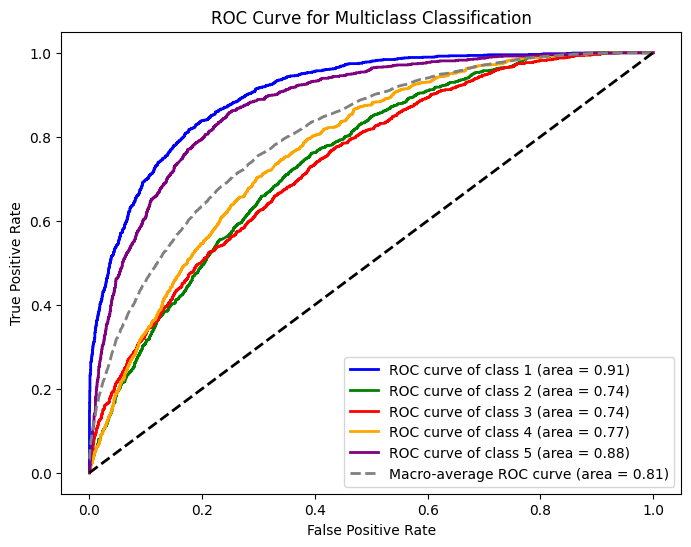

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
import numpy as np

# Initialize the logistic regression classifier and its parameters
classifier_lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
params_lr = {'C': [0.001, 0.01, 0.1, 0.5, 1 ]}

# Train and evaluate the logistic regression classifier with 5-fold cross-validation
grid_classifier_lr = GridSearchCV(classifier_lr, params_lr, cv=5, scoring='f1_macro')
grid_classifier_lr.fit(train_features, train_label)

# Display mean and standard deviation of validation scores for each combination of hyperparameters
results_cv = grid_classifier_lr.cv_results_
for mean, std, params in zip(results_cv['mean_test_score'], results_cv['std_test_score'], results_cv['params']):
    print(f"Mean F1 Score: {mean} +/- {std} for {params}")

# Display results
print('Logistic Regression Classifier with five-class labels')
print(f'Best Parameters: {grid_classifier_lr.best_params_}')
print(f'Best F1 Score: {grid_classifier_lr.best_score_}')

# Calculate the validation metrics for the optimal model
best_lr_model = grid_classifier_lr.best_estimator_
predictions_valid = best_lr_model.predict(valid_features)
print(f'Classification Report: {classification_report(valid_label, predictions_valid)}')
print(f'Confusion Matrix:\n {confusion_matrix(valid_label, predictions_valid)}')
print(f'Accuracy: {accuracy_score(valid_label, predictions_valid)}')
print(f'AUC Score: {roc_auc_score(valid_label, best_lr_model.predict_proba(valid_features), multi_class="ovo")}')
print(f'Macro F1 Score: {f1_score(valid_label, predictions_valid, average="macro")}')
print('')

# Calculate predicted probabilities for each class label on the validation dataset
probabilities_valid = best_lr_model.predict_proba(valid_features)

# Compute the ROC curve and AUC for each class separately using one-vs-all
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(valid_label==i+1, probabilities_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 5
roc_auc_macro = auc(all_fpr, mean_tpr)

# Plot the ROC curves for each class label
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i+1} (area = {roc_auc[i]:0.2f})')

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='gray', linestyle='--', lw=2, label=f'Macro-average ROC curve (area = {roc_auc_macro:0.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [13]:
# Use the optimal classifier to predict on the test dataset
predictions_test = best_lr_model.predict(test_features)
data_test['label'] = predictions_test

# Create the submission file in the required format
submission_df = pd.DataFrame({'id': data_test.index, 'label': data_test['label']})
submission_df.to_csv('Logistic_Regression_MC_submission.csv', index=False)

Mean F1 Score: 0.4292115451196163 +/- 0.005553510360696726 for {'max_depth': 3, 'n_estimators': 50}
Mean F1 Score: 0.4450300928933463 +/- 0.00697370648001367 for {'max_depth': 3, 'n_estimators': 100}
Mean F1 Score: 0.4560390690697266 +/- 0.0030321728888507227 for {'max_depth': 3, 'n_estimators': 200}
Mean F1 Score: 0.4408114158083067 +/- 0.0050736742954273955 for {'max_depth': 5, 'n_estimators': 50}
Mean F1 Score: 0.45424175217928164 +/- 0.0049078218139119115 for {'max_depth': 5, 'n_estimators': 100}
Mean F1 Score: 0.45828984175511067 +/- 0.00245449526777905 for {'max_depth': 5, 'n_estimators': 200}
Mean F1 Score: 0.4449144855014543 +/- 0.004242119552541073 for {'max_depth': 7, 'n_estimators': 50}
Mean F1 Score: 0.4516643033816429 +/- 0.0031798693663125654 for {'max_depth': 7, 'n_estimators': 100}
Mean F1 Score: 0.454018758276975 +/- 0.0028680427410985774 for {'max_depth': 7, 'n_estimators': 200}
Gradient Boosting Classifier with five-class labels
Best Parameters: {'max_depth': 5, 'n_e

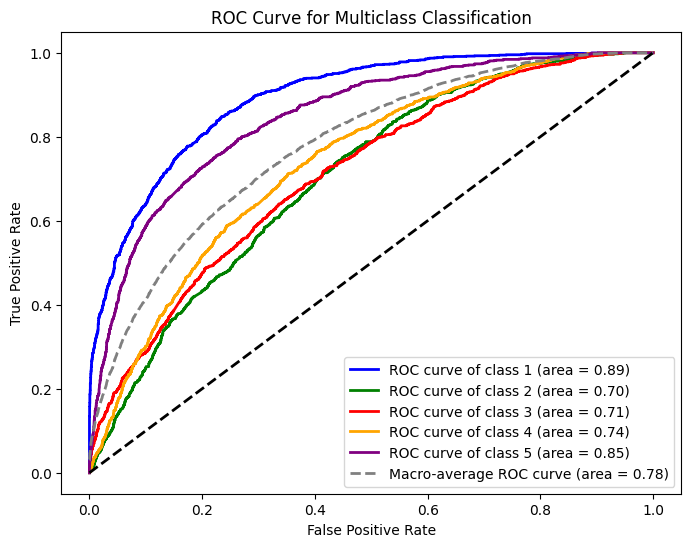

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
import numpy as np

# Initialize the Gradient Boosting classifier and its parameters
boosting_classifier = GradientBoostingClassifier(random_state=42)
boosting_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}

# Train and evaluate the Gradient Boosting classifier with 5-fold cross-validation
grid_boosting = GridSearchCV(boosting_classifier, boosting_params, cv=5, scoring='f1_macro')
grid_boosting.fit(train_features, train_label)

# Display mean and standard deviation of validation scores for each combination of hyperparameters
results_cv_boost = grid_boosting.cv_results_
for mean, std, params in zip(results_cv_boost['mean_test_score'], results_cv_boost['std_test_score'], results_cv_boost['params']):
    print(f"Mean F1 Score: {mean} +/- {std} for {params}")

# Display results
print('Gradient Boosting Classifier with five-class labels')
print(f'Best Parameters: {grid_boosting.best_params_}')
print(f'Best F1 Score: {grid_boosting.best_score_}')

# Calculate the validation metrics for the optimal model
best_boost_model = grid_boosting.best_estimator_
predictions_valid_boost = best_boost_model.predict(valid_features)
print(f'Classification Report: {classification_report(valid_label, predictions_valid_boost)}')
print(f'Confusion Matrix:\n {confusion_matrix(valid_label, predictions_valid_boost)}')
print(f'Accuracy: {accuracy_score(valid_label, predictions_valid_boost)}')
print(f'AUC Score: {roc_auc_score(valid_label, best_boost_model.predict_proba(valid_features), multi_class="ovo")}')
print(f'Macro F1 Score: {f1_score(valid_label, predictions_valid_boost, average="macro")}')
print('')

# Calculate predicted probabilities for each class label on the validation dataset
probabilities_valid_boost = best_boost_model.predict_proba(valid_features)

# Compute the ROC curve and AUC for each class separately using one-vs-all
fpr_boost = dict()
tpr_boost = dict()
roc_auc_boost = dict()
for i in range(5):
    fpr_boost[i], tpr_boost[i], _ = roc_curve(valid_label==i+1, probabilities_valid_boost[:, i])
    roc_auc_boost[i] = auc(fpr_boost[i], tpr_boost[i])

# Compute the macro-average ROC curve and AUC
all_fpr_boost = np.unique(np.concatenate([fpr_boost[i] for i in range(5)]))
mean_tpr_boost = np.zeros_like(all_fpr_boost)
for i in range(5):
    mean_tpr_boost += np.interp(all_fpr_boost, fpr_boost[i], tpr_boost[i])
mean_tpr_boost /= 5
roc_auc_macro_boost = auc(all_fpr_boost, mean_tpr_boost)

# Plot the ROC curves for each class label
plt.figure(figsize=(8,6))
colors_boost = ['blue', 'green', 'red', 'orange', 'purple']
for i in range(5):
    plt.plot(fpr_boost[i], tpr_boost[i], color=colors_boost[i], lw=2, label=f'ROC curve of class {i+1} (area = {roc_auc_boost[i]:0.2f})')

# Plot the macro-average ROC curve
plt.plot(all_fpr_boost, mean_tpr_boost, color='gray', linestyle='--', lw=2, label=f'Macro-average ROC curve (area = {roc_auc_macro_boost:0.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [14]:
# Use the optimal classifier to predict on the test dataset
predictions_test_boost = best_boost_model.predict(test_features)
data_test['label'] = predictions_test_boost

# Create the submission file in the required format
submission_df_boost = pd.DataFrame({'id': data_test.index, 'label': data_test['label']})
submission_df_boost.to_csv('Gradient_Boosting_MC_submission.csv', index=False)

Average F1 Score: 0.3656142239569621 with standard deviation of 0.007662973396753635 for parameter set: {'max_depth': 3, 'n_estimators': 50}
Average F1 Score: 0.3820172511040526 with standard deviation of 0.007969270338950497 for parameter set: {'max_depth': 3, 'n_estimators': 100}
Average F1 Score: 0.3960442345619028 with standard deviation of 0.0041527319456583535 for parameter set: {'max_depth': 3, 'n_estimators': 200}
Average F1 Score: 0.39160101290170035 with standard deviation of 0.0023894158837879883 for parameter set: {'max_depth': 5, 'n_estimators': 50}
Average F1 Score: 0.4099545312885856 with standard deviation of 0.0049436693919758246 for parameter set: {'max_depth': 5, 'n_estimators': 100}
Average F1 Score: 0.4151668331139888 with standard deviation of 0.007747996574070248 for parameter set: {'max_depth': 5, 'n_estimators': 200}
Average F1 Score: 0.399128826523512 with standard deviation of 0.004995457739551938 for parameter set: {'max_depth': 7, 'n_estimators': 50}
Averag

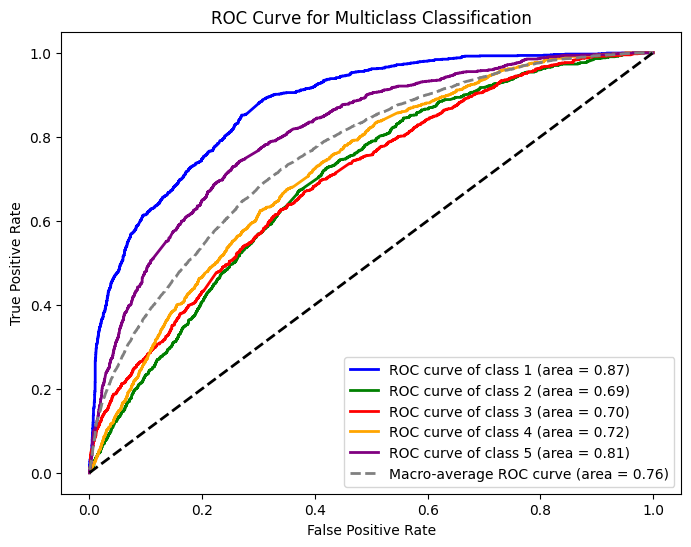

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
import re

# Random Forest Model
rf_classifier = RandomForestClassifier(random_state=42)
rf_parameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}

# Grid Search Cross Validation
rf_grid_search = GridSearchCV(rf_classifier, rf_parameters, cv=5, scoring='f1_macro')
rf_grid_search.fit(train_features, train_label)

# CV Results
cv_res = rf_grid_search.cv_results_
for mean_res, std_res, param_set in zip(cv_res['mean_test_score'], cv_res['std_test_score'], cv_res['params']):
    print("Average F1 Score:", mean_res, "with standard deviation of", std_res, "for parameter set:", param_set)

# Results
print('Random Forest Classifier - 5 Classes')
print('Optimal Parameters:', rf_grid_search.best_params_)
print('Optimal F1 Score:', rf_grid_search.best_score_)

# Validation Metrics
optimal_rf = rf_grid_search.best_estimator_
pred_valid = optimal_rf.predict(valid_features)
print('Classification Report:', classification_report(valid_label, pred_valid))
print('Confusion Matrix:\n', confusion_matrix(valid_label, pred_valid))
print('Accuracy:', accuracy_score(valid_label, pred_valid))
print('AUC Score:', roc_auc_score(valid_label, optimal_rf.predict_proba(valid_features), multi_class='ovo'))
print('Macro F1 Score:', f1_score(valid_label, pred_valid, average='macro'))
print('')

# Probabilities for Validation Set
prob_valid = optimal_rf.predict_proba(valid_features)

# ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(valid_label==i+1, prob_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-Average ROC and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(5):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= 5
roc_auc_macro = auc(all_fpr, mean_tpr)

# ROC Plot
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i in range(5):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

# Macro-Average ROC
plt.plot(all_fpr, mean_tpr, color='gray', linestyle='--', lw=2,
         label='Macro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc_macro))

# Random Line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and Legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [15]:
# Test Predictions
pred_test = optimal_rf.predict(test_features)
data_test['label'] = pred_test
# Submission File
submission_df = pd.DataFrame({'id': data_test.index, 'label': data_test['label']})
submission_df.to_csv('Random_Forest_MC_submission.csv', index=False)